In [584]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, hstack
from sklearn.cluster import KMeans
import pickle
from collections import Counter
def savePickle(target, filename):
    with open(filename, "wb") as f:
        pickle.dump(target, f)
def loadPickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [554]:
train = loadPickle("./data/train.pkl")
test = loadPickle("./data/test.pkl")

In [555]:
categoryes = sorted(train['current_service'].unique())
label_dict = {}
for i in range(len(categoryes)):
    label_dict[categoryes[i]] = i
    label_dict[i] = categoryes[i]

 - 1_total_fee array([ 0.39827125,  0.39316978,  0.39571121])
 - 2_total_fee _array([ 0.34979964,  0.35166863,  0.35014922])
 - 3_total_fee array([ 0.34979964,  0.35166863,  0.35014922])
 - 4_total_fee  array([ 0.3525123 ,  0.35381964,  0.35444017])
 - 1234 array([ 0.56280605,  0.56499034,  0.56352438])
 c =  array([ 0.29369751,  0.29296579,  0.29410951])
 ---------------------------------------------------
 ####  total fee
  - 1234 0.5604
  - 1234 + 1/2 0.5630
  - 1234 +1/2 1/3 0.5648
  - 1234 + 1/2+1/3+2/4 0.5651
  - 1234 + 1/2 1/3 1/4 2/3 2/4 0.5662
  - 1234 + 1/2 1/3 1/4 2/3 2/4 1/234 0.5665
  - 1234 + 1/2 1/3 1/4 2/3 2/4 3/4 1/234 0.5674
  
#### traffic
  - fee + local 0.5994
  - fee + local + last 0.7095
  - fee + local _ last + month 0.7472
  - fee + local _ last + month +  last/month 0.7476
  - fee + local _ last + month +  last/month local/month 0.7493
  
#### call
  -  fee + traffic + local 0.7519
  -  fee + traffic + local + service1 0.7850
  -  fee + traffic + local + service1 + service2  0.8160
  -  fee + traffic + local + service1 + service2 + s2/local 0.8162
  
#### nature
  - fee + traffic + call + age  0.8184
  - fee + traffic + call + age + gender 0.8189
  
#### statistics
  - fee + traffic + call + age + onlinetime 0.0.8280
  - fee + traffic + call + age + onlinetime + service_type 0.8352
  - fee + traffic + call + age + onlinetime + service_type + is_mix_type 0.8362
  - ... +  many_over_bill 0.8443
  - ... +  contract_type 0.8496
  - ... + contract_time 0.8683
  - ... + is_promise_low_consume 0.8689
  - ... + pay_times 0.8690
  - ... + pay_num 0.8693
#### cross feature
  - ... + traffic/fee 0.8699
  - ... + traffic/call 0.8701

In [617]:

weight_dict = {0:105, 1:110, 2:125, 3:103, 4:120, 5:133, 6:134, 7:125, 8:124, 9:111, 10:135}
lgbm = lgb.LGBMClassifier(objective = "multiclass", boosting_type =  'gbdt',
                          colsample_bytree = 0.625, importance_type = 'split', learning_rate = 0.25, max_depth = 9,
                         min_child_samples = 133, min_child_weight = 2, min_split_gain = 0.1, n_estimators = 600, n_jobs = -1,
                         num_leaves = 58, random_state = 10, reg_alpha = 0.0005, reg_lambda = 0.0471,  subsample = 0.9375,
                        subsample_for_bin = 20000, subsample_freq = 1,verbosity = 0)

# lgbm = lgb.LGBMClassifier(objective = "multiclass",  boosting_type =  'gbdt', random_state = 10, n_jobs = -1, class_weight = weight_dict)
lr = LogisticRegression()
enc = OneHotEncoder()

In [618]:
features = train[['1_total_fee', '2_total_fee', '3_total_fee', '4_total_fee']].copy()
features['1_2_total_fee_n'] = np.array(features['1_total_fee'])/np.array(features['2_total_fee'])
features['1_3_total_fee_n'] = np.array(features['1_total_fee'])/np.array(features['3_total_fee'])
features['2_4_total_fee_n'] = np.array(features['2_total_fee'])/np.array(features['4_total_fee'])
features['2_3_total_fee_n'] = np.array(features['2_total_fee'])/np.array(features['3_total_fee'])
features['3_4_total_fee_n'] = np.array(features['3_total_fee'])/np.array(features['4_total_fee'])

# traficc
features['local_trafffic_month'] = train['local_trafffic_month']
features['last_month_traffic'] = train['last_month_traffic']
features['month_traffic'] = train['month_traffic']
features['r_last_month_traffic'] = np.array(train['last_month_traffic'])/np.array(train['month_traffic'])
features['r_local_month_traffic'] = np.array(train['local_trafffic_month'])/np.array(train['month_traffic'])

#call
features['local_caller_time'] = train['local_caller_time']
features['service1_caller_time'] = train['service1_caller_time']
features['service2_caller_time'] = train['service2_caller_time']
features['s2_local_caller_time'] = np.array(train['service2_caller_time'])/np.array(train['local_caller_time'])
features['s1_s2_caller_time'] = np.array(train['service1_caller_time'])/np.array(train['service2_caller_time'])

#nature
features['age'] = train['age']
features['gender0'] = np.array(train['gender'] == 0).astype(int)
features['gender1'] = np.array(train['gender'] == 1).astype(int)
features['gender2'] = np.array(train['gender'] == 2).astype(int)

#other
features['online_time'] = train['online_time']
features['service_type'] = np.array(train['service_type'] == 4).astype(int)
features['service_type'] = np.array(train['service_type'] == 1).astype(int)
features['is_mix_service'] = train['is_mix_service']
features['many_over_bill'] = train['many_over_bill']
features['contract_type'] = np.array(train['contract_type'] == 0).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 1).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 2).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 3).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 6).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 7).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 8).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 9).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 8).astype(int)
features['contract_type'] = np.array(train['contract_type'] == 12).astype(int)
for t in sorted(train['contract_time'].unique()):
    features['contract_time_%d'%t] = np.array(train['contract_time'] == t).astype(int)
features['is_promise_low_consume'] = train['is_promise_low_consume']
# for t in sorted(train['net_service'].unique()):
#     features['net_service_%d'%t] = np.array(train['net_service'] == t).astype(int) not good
features['pay_times'] = train['pay_times']
features['pay_num'] = train['pay_num']

# cross
features['traffic_fee'] = np.array(train['month_traffic'])/np.array(train['1_total_fee'])
features = features.fillna(-1)

C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\leo\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_l

In [619]:
train_x = np.array(features).astype(float)
train_y = np.array(train['current_service'].apply(lambda x:label_dict[x]))

In [620]:
def print_stats(tdf):
    dct = Counter(tdf)
    cn = len(tdf)
    for key in dct.keys():
        print(key, round(dct[key]/cn, 3))
    print(cn, end = "\n\n")
print_stats(train_y)

0 0.179
1 0.098
2 0.045
3 0.386
4 0.051
5 0.03
6 0.028
7 0.039
8 0.044
9 0.071
10 0.028
300000



In [621]:
# kmeans1 = KMeans(n_clusters=10,  n_jobs = -1, random_state = 2018).fit(train_x)
# train_c = kmeans1.predict(train_x)
# train_c = train_c.reshape(-1,1)
# train_c = enc.fit_transform(train_c)
# train_co = hstack((train_x, train_c))

In [622]:
scores = cross_val_score(lgbm, train_x, train_y, scoring = 'f1_macro', cv  = 3, n_jobs  = -1, verbose = 2)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.1min finished


In [625]:
print(np.mean(scores))
print(np.square(np.mean(scores)))

0.88399363589
0.781444748294


In [624]:
train_x.shape

(300000, 71)

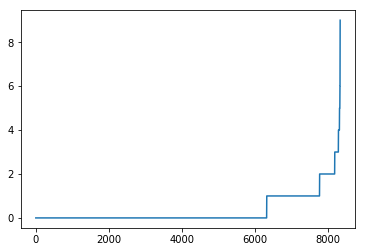

In [407]:
plt.plot(sorted(train[train['current_service'] == 99999825]['former_complaint_num']))

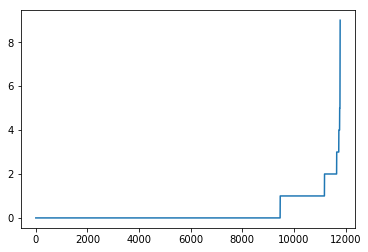

In [406]:
plt.plot(sorted(train[train['current_service'] == 99999826]['former_complaint_num']))

In [465]:
sorted(train['gender'].unique())

[0, 1, 2]

In [341]:
features.columns

Index(['1_total_fee', '2_total_fee', '3_total_fee', '4_total_fee',
       '1_2_total_fee_n', '1_3_total_fee_n', '2_4_total_fee_n',
       '2_3_total_fee_n', '3_4_total_fee_n', 'local_trafffic_month',
       'last_month_traffic', 'month_traffic', 'r_last_month_traffic',
       'r_local_month_traffic', 'local_caller_time', 'service1_caller_time',
       'service2_caller_time', 's2_local_caller_time', 's1_s2_caller_time',
       'age', 'gender0', 'gender1', 'gender2', 'online_time', 'service_type',
       'is_mix_service', 'many_over_bill', 'contract_type', 'contract_time'],
      dtype='object')

In [286]:
train.columns

Index(['service_type', 'is_mix_service', 'online_time', '1_total_fee',
       '2_total_fee', '3_total_fee', '4_total_fee', 'month_traffic',
       'many_over_bill', 'contract_type', 'contract_time',
       'is_promise_low_consume', 'net_service', 'pay_times', 'pay_num',
       'last_month_traffic', 'local_trafffic_month', 'local_caller_time',
       'service1_caller_time', 'service2_caller_time', 'gender', 'age',
       'complaint_level', 'former_complaint_num', 'former_complaint_fee',
       'current_service', 'user_id'],
      dtype='object')

In [437]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'multiclass',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 1}